<center>
    <img src="images/personal_logo.png"/>
</center>

# Deep Unsupervised Learning - Final Project
### Juan Carlos Garzon Pico
### Viviane Alves

---

<br>

<div align="center">
  
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/Juank0621)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Profile-blue?logo=linkedin)](https://www.linkedin.com/in/juancarlosgarzon)
![Python](https://badges.aleen42.com/src/python.svg)

</div>

### CIFAR10 AI System

We are developing an AI system using deep learning techniques like Convolutional Autoencoders (CAE), Variational Autoencoders (VAE), and Generative Adversarial Networks (GANs) with the CIFAR10 dataset. These models will help in facial feature extraction, attribute classification, and image generation. By leveraging these approaches, we aim to enhance face recognition, noise reduction, and synthetic face generation for improved image analysis.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm   
#from tqdm.rich import tqdm  # Import tqdm.rich for progress bars

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision.models import resnet18  # Import ResNet18
from torchsummary import summary

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('medium')
kwargs = {'num_workers': 8, 'pin_memory': True}

## PyTorch and GPU Information

This code snippet displays the PyTorch version, CUDA version, cuDNN version, and the number of GPUs available for PyTorch.

The first line prints the PyTorch version being used.
The second and third lines retrieve and display the CUDA and cuDNN versions used by PyTorch.
The final line shows the number of GPUs available for PyTorch, helping to confirm whether your system is utilizing the GPU for processing.
This is useful for ensuring that your environment is correctly set up to use GPU acceleration.

In [2]:
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.6.0+cu124


In [ ]:
# Get the CUDA version used by PyTorch
cuda_version = torch.version.cuda
print("CUDA Version:", cuda_version)

# Get the cuDNN version used by PyTorch
cudnn_version = torch.backends.cudnn.version()
print("cuDNN Version:", cudnn_version)

# Get the number of GPUs available
num_gpus = torch.cuda.device_count()
print("Num GPUs Available:", num_gpus)

CUDA Version: 12.4
cuDNN Version: 90100


Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that.

In [5]:
!nvidia-smi

Fri Apr  4 11:07:29 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:01:00.0  On |                  N/A |
| 30%   32C    P2              35W / 320W |    840MiB / 16376MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Dataset Directory

Here we define the transformations to be applied to the images in the CIFAR10 dataset.

In [ ]:
# Define transformations for the CIFAR10 dataset
# We normalize the images to have a mean of 0.5 and a standard deviation of 0.5 for each channel.
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()  # No normalization
])

In [8]:
dummy_dataset = CIFAR10(root='./data', train=True, download=True)
print(dummy_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Custom dataset class to filter CIFAR10 images by a specific class.
class OneClassDatasetCIFAR10(CIFAR10):
    def __init__(self, root_dir, real_class=0, transform=None, train=True, download=True):
        super().__init__(root=root_dir, transform=transform, train=train, download=download)
        self.samples = [(img, label) for img, label in zip(self.data, self.targets) if label == real_class]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, _ = self.samples[idx]
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, 0  # dummy label

## Variational autoencoder (VAE)

Encoder for the VAE using convolutional layers. It reduces the spatial dimensions of the input image while increasing the number of feature maps, eventually flattening the output for the latent space.

In [ ]:
# Encoder: downsampling convolutions
class VAE_Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # 32 -> 16
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # 16 -> 8
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.Conv2d(128, 256, 4, 2, 1),  # 8 -> 4
            nn.BatchNorm2d(256),
            nn.SiLU(),
            nn.Conv2d(256, 512, 4, 2, 1),  # 4 -> 2
            nn.BatchNorm2d(512),
            nn.SiLU(),
        )
        self.flatten = nn.Flatten()
        self.fc_mean = nn.Linear(512 * 2 * 2, latent_dim)
        self.fc_logvar = nn.Linear(512 * 2 * 2, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        return self.fc_mean(x), self.fc_logvar(x)

Decoder for the VAE using transposed convolutional layers. It reconstructs the image from the latent space back to the original 32x32 resolution with 3 channels.

In [ ]:
# Decoder: upsampling with transposed convolutions
class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512 * 2 * 2)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (512, 2, 2)),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.SiLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, z):
        x = self.fc(z)
        return self.decoder(x)

Variational Autoencoder (VAE) combining the encoder and decoder. It includes the reparameterization trick to sample from the latent space.

In [ ]:
# Full VAE combining encoder and decoder
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = VAE_Encoder(latent_dim)
        self.decoder = VAE_Decoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x_hat = self.decoder(z)
        return x_hat, mean, logvar

This function computes the **Mahalanobis distance** between a data point and a distribution.

### Purpose

The Mahalanobis distance measures how far a point is from the mean of a distribution, taking into account the correlations between variables. It's commonly used for:

- Detecting outliers
- Measuring similarity in multivariate data
- Statistical classification

### Formula

Mahalanobis distance:  
$$D_M(x) = \sqrt{(x - \mu)^T \Sigma^{-1} (x - \mu)}$$

Where:
- $x$ is the data point  
- $\mu$ is the mean of the data  
- $\Sigma$ is the covariance matrix

### Key Point

Unlike Euclidean distance, Mahalanobis distance accounts for variable scale and correlation, making it more robust for multivariate analysis.

In [ ]:
# VAE loss
def vae_loss_function(x, x_hat, mean, log_var, beta=0.1):
    recon_loss = F.mse_loss(x_hat, x, reduction='mean')
    kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    kl_div = torch.clamp(kl_div, min=-1e6, max=1e6)
    return recon_loss + beta * kl_div / x.size(0)

# Train one epoch
def train_vae_epoch(vae, train_loader, optimizer):
    vae.train()
    total_loss = 0
    for inputs, _ in tqdm(train_loader, desc="Training VAE Epoch", leave=False):
        inputs = inputs.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = vae(inputs)
        loss = vae_loss_function(inputs, x_hat, mean, log_var, beta=0.1)
        if torch.isnan(loss):
            print("NaN detected in loss! Skipping batch.")
            continue
        loss.backward()
        for name, param in vae.named_parameters():
            if param.grad is not None:
                print(f"Gradient for {name}: {param.grad.norm().item()}")
        torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation
def evaluate_vae(vae, val_loader):
    vae.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            x_hat, mean, log_var = vae(inputs)
            loss = vae_loss_function(inputs, x_hat, mean, log_var)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Mahalanobis distance
def calculate_mahalanobis_distance(mean, covariance, x):
    diff = x - mean
    inv_covariance = torch.linalg.inv(covariance)
    distance = torch.sqrt(torch.mm(torch.mm(diff.unsqueeze(0), inv_covariance), diff.unsqueeze(1)))
    return distance.item()

def test_vae(vae, test_loader, threshold):
    vae.eval()
    anomalies = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            x_hat, mean, log_var = vae(inputs)
            z = vae.reparameterize(mean, log_var)
            distances = [calculate_mahalanobis_distance(mean[i], torch.eye(mean.size(1)).to(device), z[i]) for i in range(z.size(0))]
            anomalies.extend([d > threshold for d in distances])
    return anomalies


In [ ]:
# Main function to train the VAE for all classes
def main_vae():
    latent_dim = 256
    num_epochs = 100
    learning_rate = 1e-3
    threshold = 5.0

    vae = VAE(latent_dim).to(device)
    summary(vae, input_size=(3, 32, 32))
    optimizer = torch.optim.AdamW(vae.parameters(), lr=learning_rate)

    all_train_losses = []
    all_val_losses = []

    for real_class in range(10):
        print(f"\nTraining VAE for class {real_class}...")
        train_dataset = OneClassDatasetCIFAR10(root_dir='data', real_class=real_class, transform=transform, train=True, download=True)
        val_dataset = OneClassDatasetCIFAR10(root_dir='data', real_class=real_class, transform=transform, train=False, download=True)
        test_dataset = CIFAR10(root='data', train=False, transform=transform, download=True)

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, **kwargs)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, **kwargs)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, **kwargs)

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            train_loss = train_vae_epoch(vae, train_loader, optimizer)
            val_loss = evaluate_vae(vae, val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        torch.save(vae.state_dict(), f'models/vae/vae_class_{real_class}_weights.pth')

        print(f"Testing VAE for class {real_class}...")
        anomalies = test_vae(vae, test_loader, threshold)
        print(f"Anomalies detected for class {real_class}: {sum(anomalies)} out of {len(anomalies)}")

        visualize_reconstruction(vae, val_dataset, real_class)

    return all_train_losses, all_val_losses

mean std comparae mean std from de anamalies.

In [16]:
# Call the main function for VAE
all_train_losses, all_val_losses = main_vae()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/juangarzon/miniforge3/envs/dul/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/juangarzon/miniforge3/envs/dul/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/juangarzon/miniforge3/envs/dul/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_209680/925684213.py", line 18, in __getitem__
    image = self.transform(image)
  File "/home/juangarzon/miniforge3/envs/dul/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
  File "/home/juangarzon/miniforge3/envs/dul/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 137, in __call__
    return F.to_tensor(pic)
  File "/home/juangarzon/miniforge3/envs/dul/lib/python3.10/site-packages/torchvision/transforms/functional.py", line 142, in to_tensor
    raise TypeError(f"pic should be PIL Image or ndarray. Got {type(pic)}")
TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>


In [ ]:
# Function to plot training and validation losses for each class in separate plots
def plot_losses_per_class_separately(all_train_losses, all_val_losses):
    num_classes = len(all_train_losses)
    for class_index in range(num_classes):
        plt.figure(figsize=(10, 5))
        plt.plot(all_train_losses[class_index], label='Train Loss')
        plt.plot(all_val_losses[class_index], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Losses for Class {class_index}')
        plt.legend()
        plt.show()

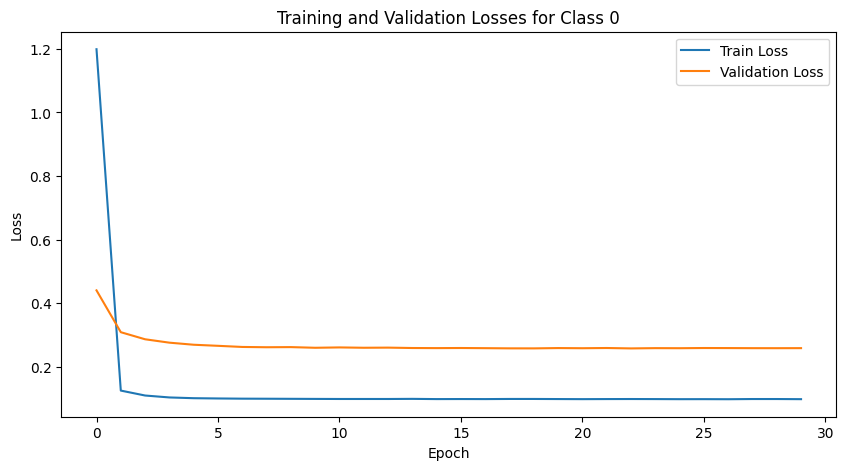

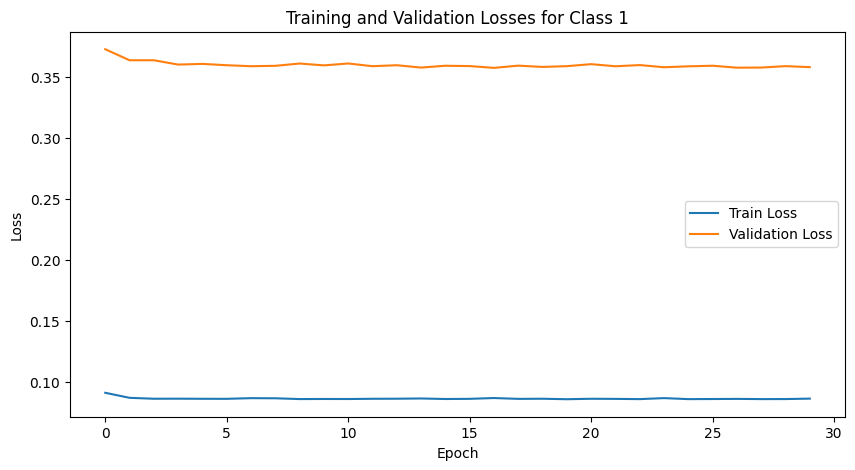

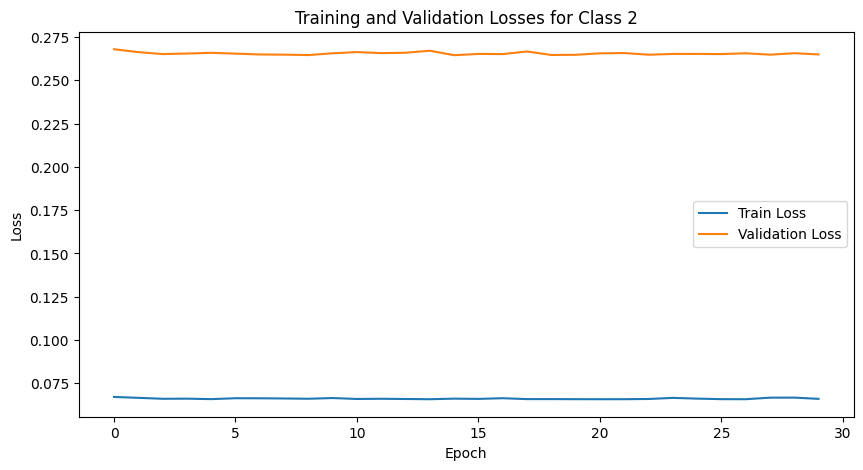

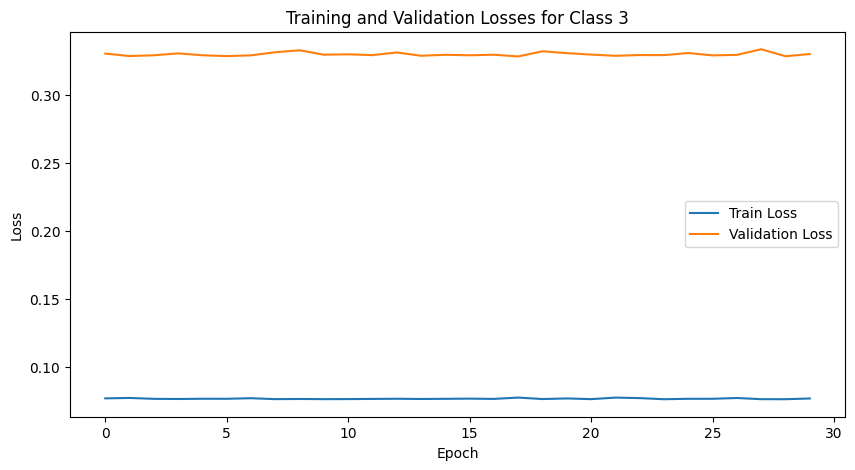

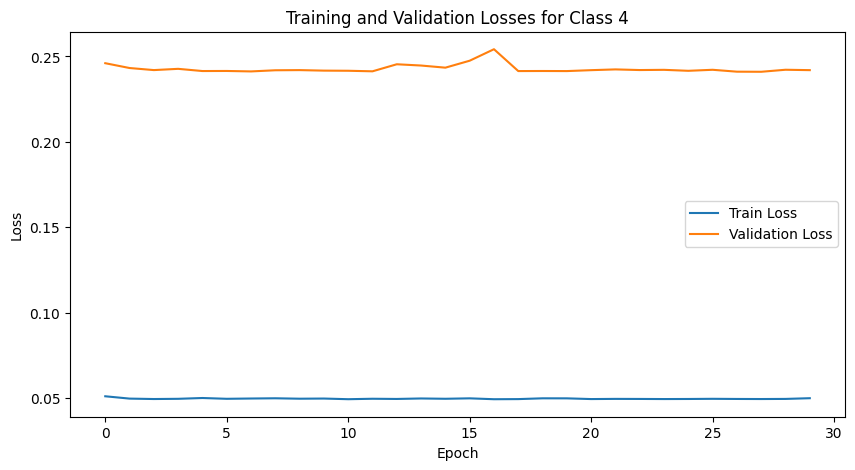

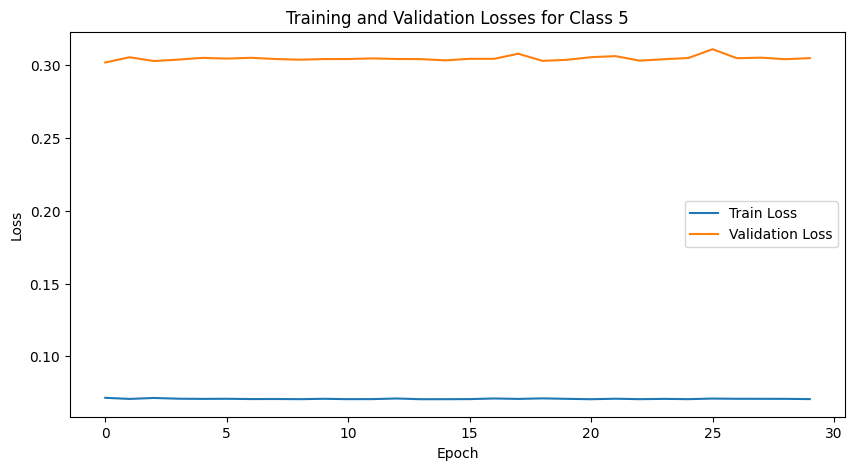

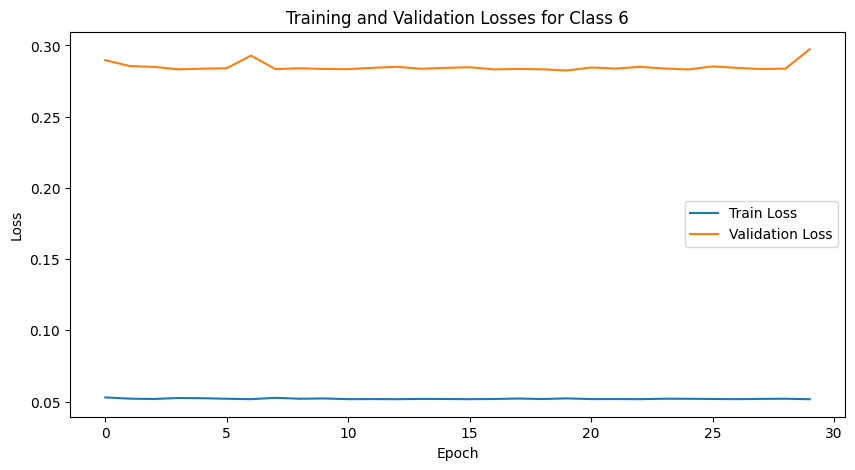

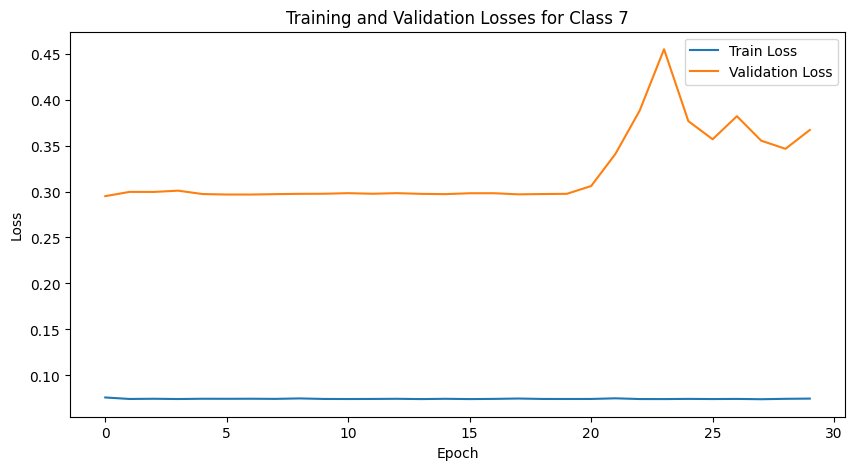

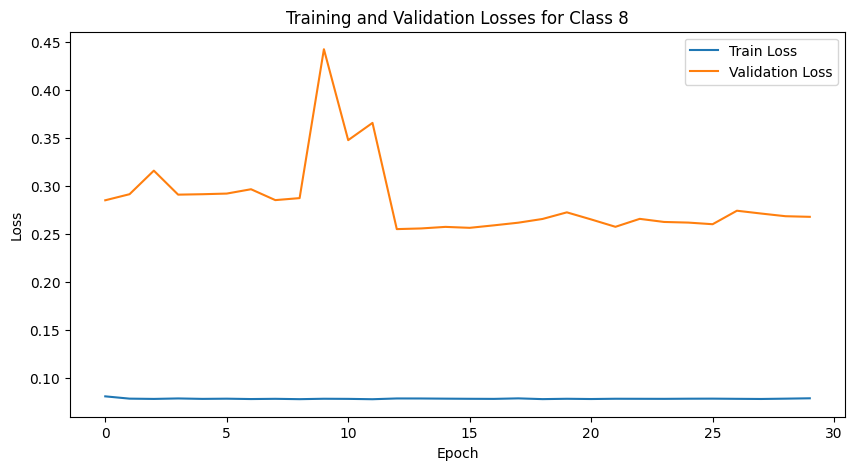

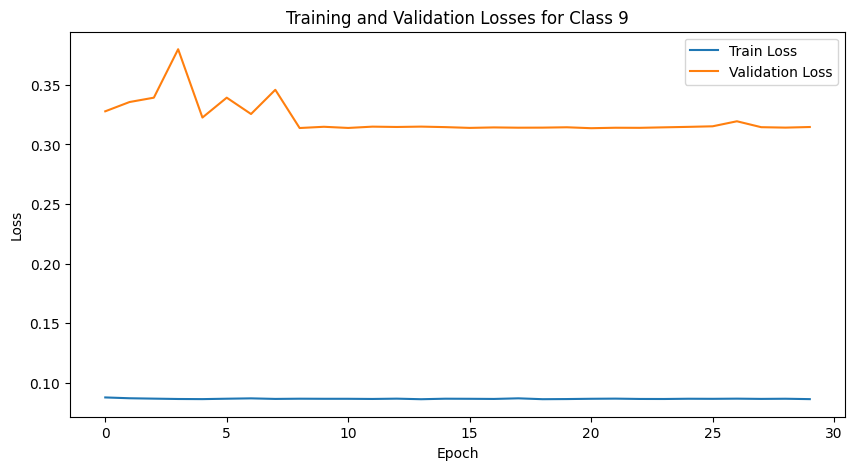

In [ ]:
# Generate separate plots for losses after training
plot_losses_per_class_separately(all_train_losses, all_val_losses)

In [ ]:
# Visualize reconstruction
def visualize_reconstruction(vae, dataset, class_index):
    vae.eval()
    with torch.no_grad():
        image, _ = dataset[np.random.randint(len(dataset))]
        image = image.unsqueeze(0).to(device)
        reconstructed, _, _ = vae(image)

        original_image = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        reconstructed_image = reconstructed.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        reconstructed_image = ((reconstructed_image + 1) / 2).clip(0, 1)  # from [-1, 1] to [0, 1]

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title(f'Original Image (Class {class_index})')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed_image)
        plt.title(f'Reconstructed Image (Class {class_index})')
        plt.axis('off')
        plt.show()

Visualizing reconstruction for class 0...


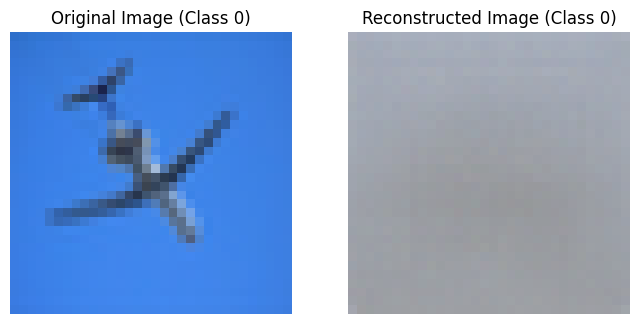

Visualizing reconstruction for class 1...


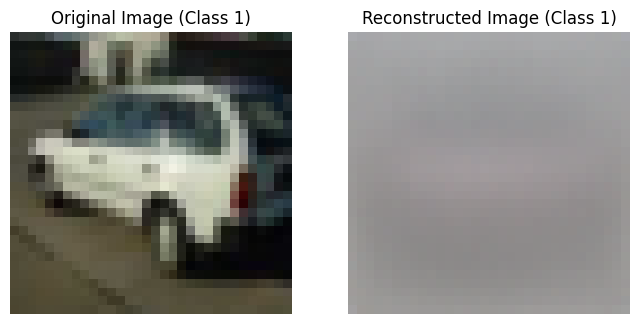

Visualizing reconstruction for class 2...


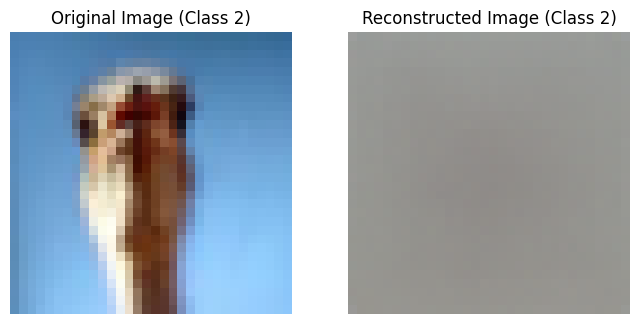

Visualizing reconstruction for class 3...


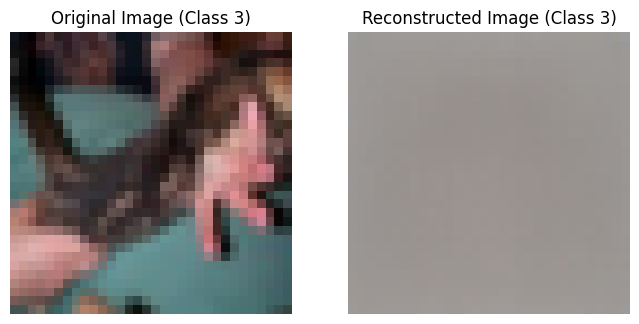

Visualizing reconstruction for class 4...


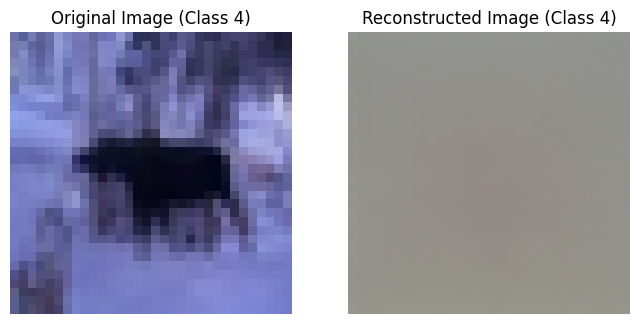

Visualizing reconstruction for class 5...


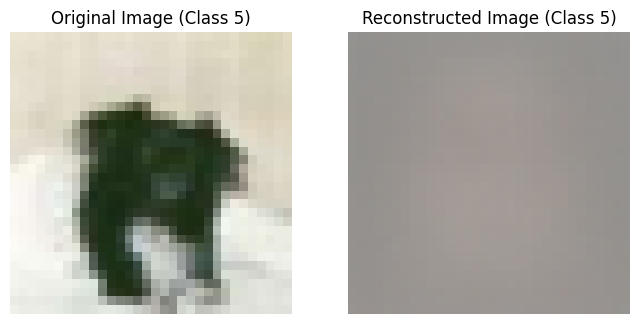

Visualizing reconstruction for class 6...


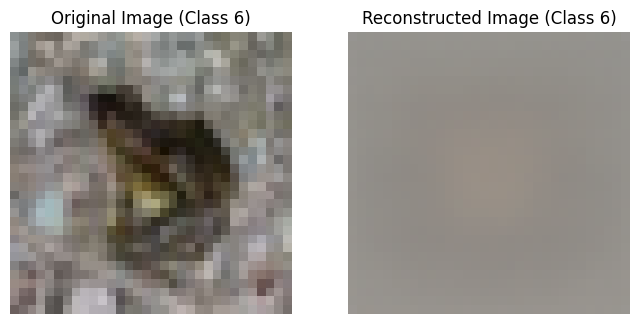

Visualizing reconstruction for class 7...


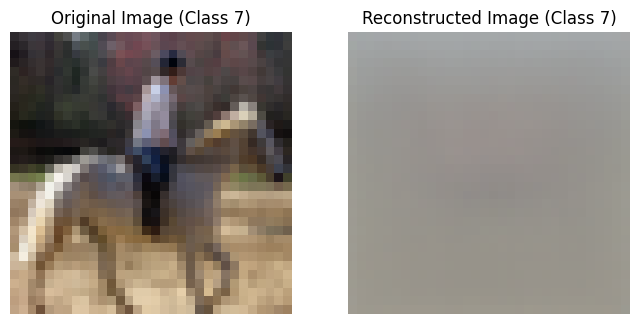

Visualizing reconstruction for class 8...


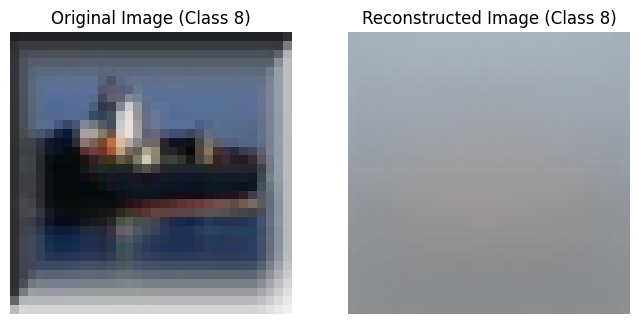

Visualizing reconstruction for class 9...


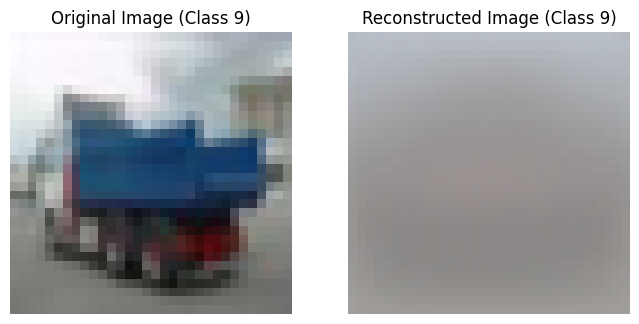

In [ ]:
# Visualize reconstruction for each class
for class_index in range(10):
    print(f"Visualizing reconstruction for class {class_index}...")
    # Load the corresponding dataset and model for the class
    val_dataset = OneClassDatasetCIFAR10(root_dir='data', real_class=class_index, transform=transform, train=False, download=True)
    vae = VAE(latent_dim=128).to(device)
    vae.load_state_dict(torch.load(f'models/vae/vae_class_{class_index}_weights.pth'))
    visualize_reconstruction(vae, val_dataset, class_index)

In [ ]:
# Function to generate a confusion matrix for anomaly detection
def generate_confusion_matrix(vae, real_class, threshold, transform):
    vae.eval()
    all_labels = []
    all_predictions = []

    # Load datasets for the real class and other classes
    real_dataset = OneClassDatasetCIFAR10(root_dir='data', real_class=real_class, transform=transform, train=False, download=True)
    other_dataset = [OneClassDatasetCIFAR10(root_dir='data', real_class=i, transform=transform, train=False, download=True)
                     for i in range(10) if i != real_class]

    # Evaluate real class (normal samples)
    with torch.no_grad():
        for image, _ in real_dataset:
            image = image.unsqueeze(0).to(device)
            x_hat, mean, log_var = vae(image)
            z = vae.reparameterize(mean, log_var)
            distance = calculate_mahalanobis_distance(mean[0], torch.eye(mean.size(1)).to(device), z[0])
            all_labels.append(0)  # Label 0 for normal
            all_predictions.append(1 if distance > threshold else 0)

    # Evaluate other classes (anomalous samples)
    with torch.no_grad():
        for dataset in other_dataset:
            for image, _ in dataset:
                image = image.unsqueeze(0).to(device)
                x_hat, mean, log_var = vae(image)
                z = vae.reparameterize(mean, log_var)
                distance = calculate_mahalanobis_distance(mean[0], torch.eye(mean.size(1)).to(device), z[0])
                all_labels.append(1)  # Label 1 for anomaly
                all_predictions.append(1 if distance > threshold else 0)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for Class {real_class}")
    plt.show()

Generating confusion matrix for class 0...


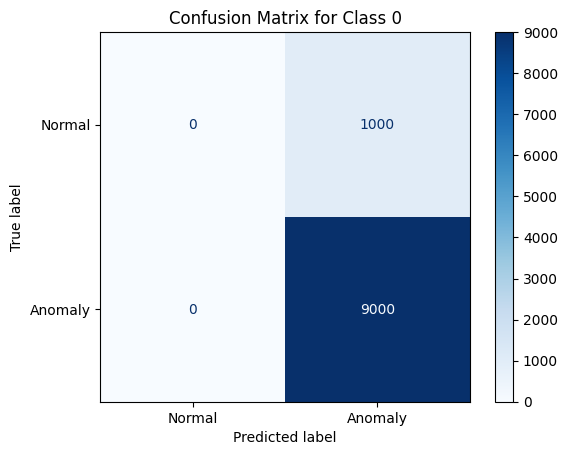

Generating confusion matrix for class 1...


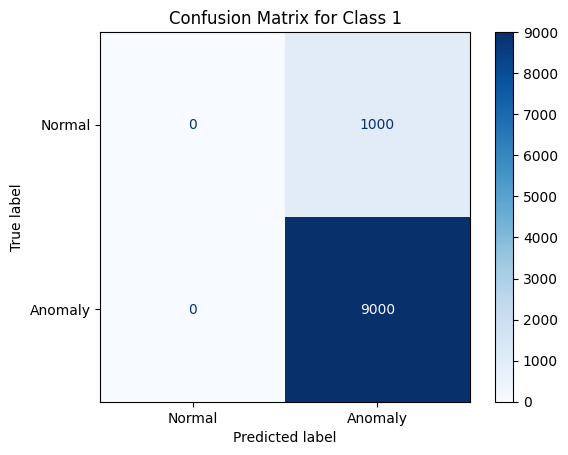

Generating confusion matrix for class 2...


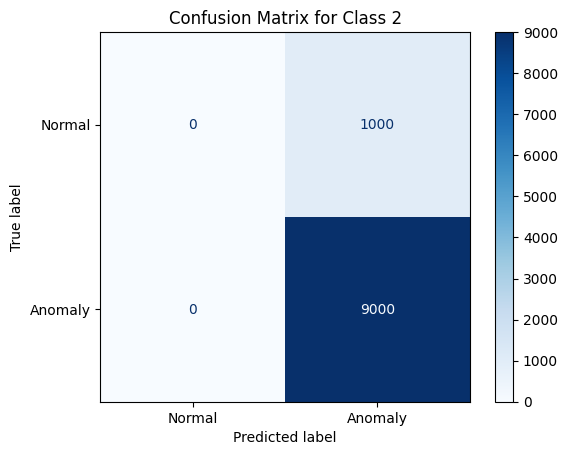

Generating confusion matrix for class 3...


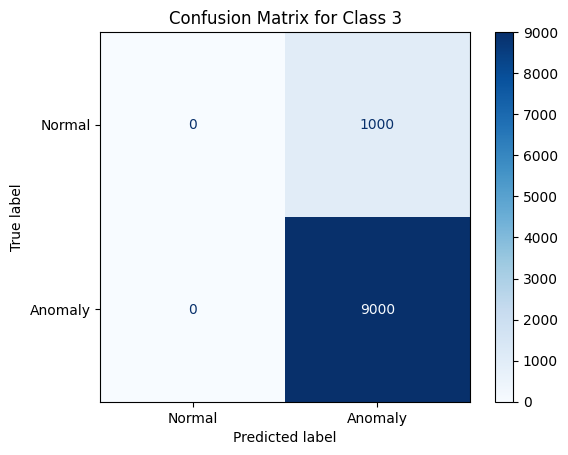

Generating confusion matrix for class 4...


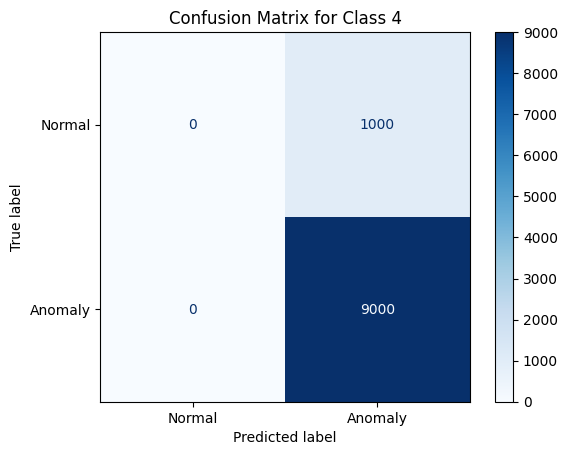

Generating confusion matrix for class 5...


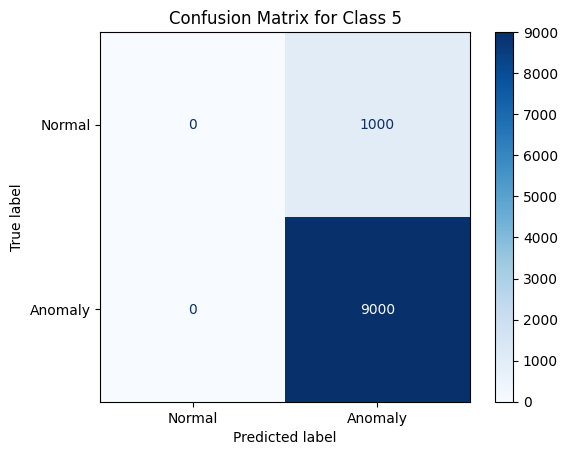

Generating confusion matrix for class 6...


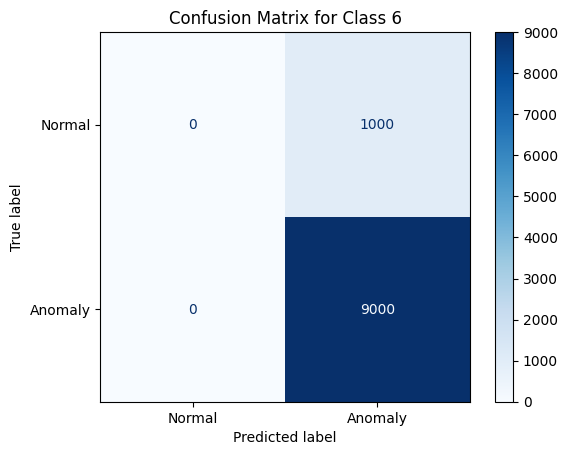

Generating confusion matrix for class 7...


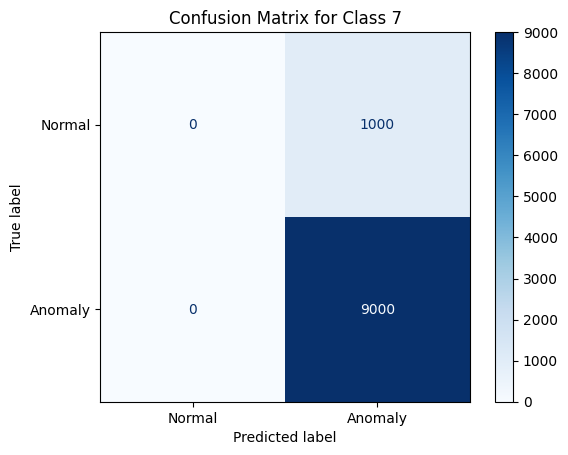

Generating confusion matrix for class 8...


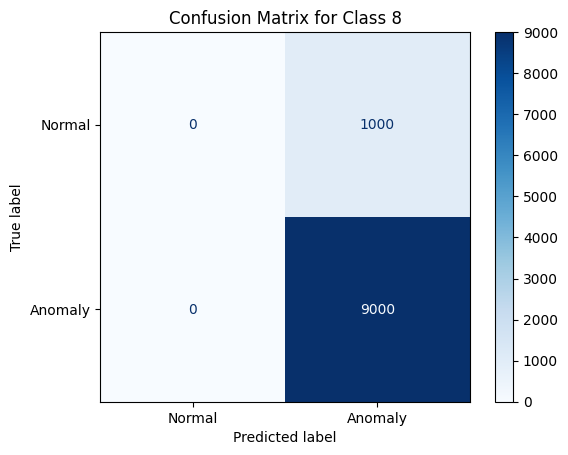

Generating confusion matrix for class 9...


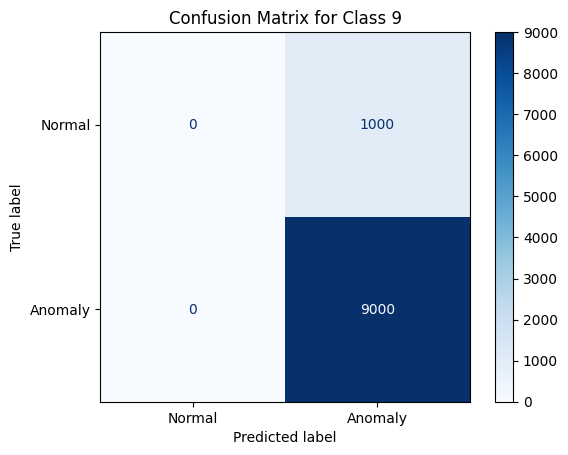

In [ ]:
# Generate confusion matrices for all classes
threshold = 5.0  # Example threshold for Mahalanobis distance
for class_index in range(10):
    print(f"Generating confusion matrix for class {class_index}...")
    vae = VAE(latent_dim=128).to(device)
    vae.load_state_dict(torch.load(f'models/vae/vae_class_{class_index}_weights.pth'))
    generate_confusion_matrix(vae, class_index, threshold, transform)

## Generative Adversarial Network (GAN)

## Citation

```bibtex
@techreport{krizhevsky2009learning,
  title = {Learning Multiple Layers of Features from Tiny Images},
  author = {Alex Krizhevsky},
  institution = {University of Toronto},
  year = {2009},
  url = {https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf}
}